In [1]:
#%%appyter init
import os, sys; sys.path.insert(0, os.path.realpath('..'))
from appyter import magic
magic.init(lambda _=globals: _())

In [2]:
%matplotlib inline
# Imports
## Data processing
import pandas as pd
import numpy as np
import scipy as sp
## Machine Learning
import sklearn as sk
from sklearn import (
    calibration,
    decomposition,
    ensemble,
    feature_selection,
    linear_model,
    manifold,
    metrics,
    model_selection,
    multioutput,
    pipeline,
    preprocessing,
    svm,
    tree,
)
## Plotting
from matplotlib import pyplot as plt
## Drugmonizome API
from drugmonizome import Drugmonizome
from drugmonizome import parse_multiple
# Utility
import os
import re
import json
from functools import reduce
from IPython.display import display

In [22]:
rng = 2020
pd.set_option('display.max_rows', None)

## Select Inputs

Given a target attribute of interest, we will use machine learning to predict drugs that are strongly correlated with that target. Using the Drugmonizome datasets (stored locally), we load the dataset containing the target attribute as well as a number of well-populated Omics datasets for more drugs and features and build a large sparse dataframe.

Select Omics datasets are downloaded and joined on the drug producing a large association matrix. Only association is preserved in order to create a binary classification task.

In [4]:
%%appyter hide
{% do SectionField(
    title='ATTRIBUTE DATASET SELECTION',
    subtitle='Select the input datasets to use for learning and classification.',
    name='ATTRIBUTES',
) %}

{% set exprdatasets = MultiChoiceField(
    name='exprdatasets',
    label='L1000',
    choices=[
        'L1000FWD Downregulated GO Biological Processes',
        'L1000FWD Downregulated GO Cellular Components',
        'L1000FWD Downregulated GO Molecular Function',
        'L1000FWD Downregulated KEGG Pathways',
        'L1000FWD Downregulated Signatures',
        'L1000FWD Predicted Side Effects',
        'L1000FWD Upregulated GO Biological Process',
        'L1000FWD Upregulated GO Cellular Components',
        'L1000FWD Upregulated GO Molecular Function',
        'L1000FWD Upregulated KEGG Pathways',
        'L1000FWD Upregulated Signatures',
    ],
    default=[],
    section='ATTRIBUTES'
) %}

{% set targetdatasets = MultiChoiceField(
    name='targetdatasets',
    label='Drug Targets and Associated Genes',
    choices=[
        'Downregulated CREEDS Signatures',
        'Upregulated CREEDS Signatures',
        'DrugCentral Targets',
        'DrugRepurposingHub Drug Targets',
        'Drugbank Small Molecule Carriers',
        'Drugbank Small Molecule Enzymes',
        'Drugbank Small Molecule Targets',
        'Drugbank Small Molecule Transporters',
        'Geneshot Associated Genes',
        'Geneshot Predicted AutoRIF Genes',
        'Geneshot Predicted Coexpression Genes',
        'Geneshot Predicted Enrichr Genes',
        'Geneshot Predicted GeneRIF Genes',
        'Geneshot Predicted Tagger Genes',
        'KinomeScan Kinases',
        'PharmGKB Single Nucleotide Polymorphisms',
        'STITCH Targets',
    ],
    default=[],
    section='ATTRIBUTES'
) %}

{% set indicationdatasets = MultiChoiceField(
    name='indicationdatasets',
    label='Indications, Modes of Action, and Side Effects',
    choices=[
        'ATC Codes Drugsetlibrary',
        'DrugRepurposingHub Mechanisms of Action',
        'PharmGKB OFFSIDES Side Effects',
        'SIDER Indications',
        'SIDER Side Effects',
    ],
    default=[],
    section='ATTRIBUTES'
) %}

{% set structuraldatasets = MultiChoiceField(
    name='structuraldatasets',
    label='Structural Features',
    choices=[
        'RDKIT MACCS Chemical Fingerprints'
    ],
    default=[],
    section='ATTRIBUTES'
) %}

In [5]:
%%appyter hide
{% do SectionField(
    title='TARGET DATASET SELECTION',
    subtitle='Select the datasets to use for learning and classification.',
    name='TARGET',
) %}

{% set drugformat = ChoiceField(
    name='drugformat',
    label='Input Format',
    default='Drug Name',
    choices=[
        'Drug Name',
        'InChI Key'
    ],
    section='TARGET'
) %}

{% set drughitlist = FileField(
    name='drughitlist',
    label='Upload List of Drug Hits',
    default='COVID19drugsets/all_hits.txt',
    section='TARGET'
) %}

In [6]:
%%appyter code_exec
attribute_datasets = {{ exprdatasets }} + {{ targetdatasets }} + {{ indicationdatasets }} + {{ structuraldatasets }}

df_attributes = list(Drugmonizome.download_df(
    [dataset
     for dataset in attribute_datasets]
))

# Assemble all attribute datasets
if len(df_attributes) > 1:
    # Obtain merged dataframe with omics and target data
    df = reduce(
        lambda a, b: pd.merge( # Merge two dataframes item by item
            a, # left
            b, # right
            # Items with the same left and right index are merged
            left_index=True,
            right_index=True,
            how='outer', # Keep mis-matched index
        ),
        df_attributes,
    )
else:
    df = df_attributes[0]

df = df.fillna(0)
X = df.applymap(lambda f: 1 if f!=0 else 0)
print('Total Shape:', X.shape)
display(X.head())

```python
attribute_datasets = ['L1000FWD Downregulated GO Biological Processes', 'L1000FWD Upregulated GO Biological Process'] + ['Geneshot Predicted Coexpression Genes'] + ['ATC Codes Drugsetlibrary'] + ['RDKIT MACCS Chemical Fingerprints']
df_attributes = list(Drugmonizome.download_df(
    [dataset
     for dataset in attribute_datasets]
))
# Assemble all attribute datasets
if len(df_attributes) > 1:
    # Obtain merged dataframe with omics and target data
    df = reduce(
        lambda a, b: pd.merge( # Merge two dataframes item by item
            a, # left
            b, # right
            # Items with the same left and right index are merged
            left_index=True,
            right_index=True,
            how='outer', # Keep mis-matched index
        ),
        df_attributes,
    )
else:
    df = df_attributes[0]
df = df.fillna(0)
X = df.applymap(lambda f: 1 if f!=0 else 0)
print('Total Shape:', X.shape)
display(X.head())
```

Total Shape: (14427, 11854)


,'de novo' posttranslational protein folding (GO:0051084)_x,ATP generation from ADP (GO:0006757)_x,B cell activation (GO:0042113)_x,C21-steroid hormone metabolic process (GO:0008207)_x,CENP-A containing chromatin organization (GO:0061641),CENP-A containing nucleosome assembly (GO:0034080),DNA biosynthetic process (GO:0071897),DNA conformation change (GO:0071103),"DNA damage response, signal transduction by p53 class mediator (GO:0030330)_x","DNA damage response, signal transduction by p53 class mediator resulting in cell cycle arrest (GO:0006977)_x",...,MACCS90,MACCS91,MACCS92,MACCS93,MACCS94,MACCS95,MACCS96,MACCS97,MACCS98,MACCS99
AAADKYXUTOBAGS-XCBNKYQSSA-N,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
AAALVYBICLMAMA-UHFFFAOYSA-N,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
AABLHGPVOULICI-BRJGLHKUSA-N,0,0,0,0,0,0,0,0,0,0,...,1,1,0,1,0,1,1,0,1,0
AACACXATQSKRQG-UHFFFAOYSA-L,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
AACFPJSJOWQNBN-UHFFFAOYSA-N,0,0,0,1,0,0,0,0,0,0,...,1,1,1,0,0,1,1,0,0,0


In [7]:
%%appyter code_exec

with open({{ drughitlist }}, 'r') as hits_file:
    drug_hits = set(drug.strip() for drug in hits_file.read().strip().split('\n') 
                    if len(drug.strip()) > 0)

{% if drugformat.value == 'Drug Name' %}
drug_hits = Drugmonizome.get_InChI_keys(drug_hits)
{% endif %}

```python
with open('COVID19drugsets/all_hits.txt', 'r') as hits_file:
    drug_hits = set(drug.strip() for drug in hits_file.read().strip().split('\n')
                    if len(drug.strip()) > 0)
drug_hits = Drugmonizome.get_InChI_keys(drug_hits)
```

Number of hits queried: 214
Number of matches: 168 / 14579
Missing in Drugmonizome (78): {'imd0354', 'lgk-974', 'sb-612111', 'thioguanine', 'raf265 derivative', 'gitoxigenin diacetate', 'sdz-62-434', 'triparanol', 'gsk2606414', 'adoprazine', 'dihydrorotenone', 'amg-2674', 'mk-886', 'calcipotriene', 'gs-441524', 'int-747', 'zotarolimus', 'byl719', 'ono 5334', 'ipag', 'cx-4945', 'carazolol', 'rbad', 'thioguanosine', 'yh-1238', 'lactoferrin', 'ai-10-49', 'convallatoxin', 'mln-3897', 'cetylpyridinium chloride', 'ly2228820', 'ipi-145', 'antimycin a', 'vby-825', 'diydroxyflavone', 'z-fa-fmk', 'ethaverine', 'kw 8232', 'n-tert-butylisoquine', 'torin 2', 'harringtonine', 'cyclopiazonic acid', 'nsc319726', 'tilorone', 'bp-897', 'ldg-1550', 'torin 1', 'nebivolol hcl', 'cepharanthine', 'al 3152', 'amodiaquin', 'elopiprazole', 'mundulone', 'aq-13', 'pf-670462', 'oxyclozanide', 'vu 0155069', 'ac1ndss5', 'stf-62247', 'strophanthidinic acid', 'zaleplon gr', 'dihydromunduletone', 'sl-11128', 'as-252424

For the target class, we build a list (1 if drug is associated, otherwise 0)

In [8]:
y = np.array([drug in drug_hits for drug in X.index]).astype(np.int8)
print('Known Targets: %d (%0.3f %%)' % (y.sum(), 100*y.sum()/len(y)))

Known Targets: 168 (1.164 %)


We produce a target array containing 1 if the drug is associated and 0 otherwise.

In [9]:
# Output data shapes
print('Input shape:', X.shape)
print('Target shape:', y.shape)

Input shape: (14427, 11854)
Target shape: (14427,)


In [10]:
%%appyter hide
{% do SectionField(
    title='SETTINGS',
    subtitle='From here you can select the various available Machine Learning algorithms, their unique settings, and the methods to use to evaluate the classifier.',
    name='SETTINGS',
) %}
{% set dimensionality_reduction = ChoiceField(
    name='dimensionality_reduction',
    label='Dimensionality Reduction Algorithm',
    description='A dimensionality reduction algorithm should be selected to improve the quality of the classifier.',
    default='PCA',
    choices={
        'PCA': 'sk.decomposition.PCA(n_components=64)',
        'TruncatedSVD': 'sk.decomposition.TruncatedSVD(n_components=64)',
        'IncrementalPCA': 'sk.decomposition.IncrementalPCA(n_components=64)',
        'ICA': 'sk.decomposition.FastICA(n_components=64)',
        'SparsePCA': 'sk.decomposition.SparsePCA(n_components=64)',
    },
    section='SETTINGS'
) %}

In [11]:
%%appyter markdown
## Dimensionality Reduction

We reduce the dimensionality of our omics feature space with {{ dimensionality_reduction.value }}.

## Dimensionality Reduction
We reduce the dimensionality of our omics feature space with sk.decomposition.PCA(n_components=64).

```python
clf_dimensionality_reduction = sk.decomposition.PCA(n_components=64)
X_reduced = clf_dimensionality_reduction.fit_transform(X.values)
plt.title('Low dimension representation')
plt.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    c=y,
)
plt.show()
```

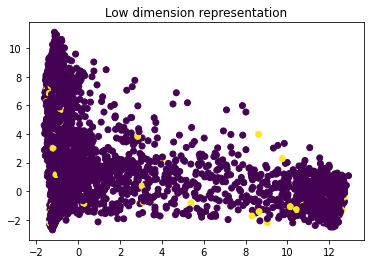

In [12]:
%%appyter code_exec
clf_dimensionality_reduction = {{ dimensionality_reduction }}
X_reduced = clf_dimensionality_reduction.fit_transform(X.values)
{% if dimensionality_reduction == 'PCA' %}
print('Explained variance:', np.sum(clf_dimensionality_reduction.explained_variance_))
{% endif %}
plt.title('Low dimension representation')
plt.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    c=y,
)
plt.show()

In [13]:
%%appyter hide
{% set feature_selection = ChoiceField(
    name='feature_selection',
    label='Machine Learning Feature Selection',
    default='None',
    choices={
        'None': 'None',
        'SelectFromLinearSVC': 'sk.feature_selection.SelectFromModel(sk.svm.LinearSVC(loss="squared_hinge", penalty="l1", dual=False))',
        'SelectFromExtraTrees': 'sk.feature_selection.SelectFromModel(sk.ensemble.ExtraTreesClassifier())',
        'SelectKBest': 'sk.feature_selection.SelectKBest("f_classif")',
        'SelectKBestChi2': 'sk.feature_selection.SelectKBest("chi2")',
        'SelectKBestMultiInfo': 'sk.feature_selection.SelectKBest("mutual_info_classif")',
    },
    section='SETTINGS'
) %}
{% set cv_algorithm = ChoiceField(
    name='cv_algorithm',
    label='Cross Validation Algorithm',
    default='StratifiedKFold',
    value='KFold',
    choices={
        'KFold': 'sk.model_selection.KFold',
        'GroupKFold': 'sk.model_selection.GroupKFold',
        'RepeatedKFold': 'sk.model_selection.RepeatedKFold',
        'StratifiedKFold': 'sk.model_selection.StratifiedKFold',
        'RepeatedStratifiedKFold': 'sk.model_selection.RepeatedStratifiedKFold',
    },
    section='SETTINGS',
) %}
{% set algorithm = ChoiceField(
    name='algorithm',
    label='Machine Learning Algorithm',
    default='RandomForestClassifier',
    description='A machine learning algorithm should be selected to construct the predictive model.',
    choices={
        'GradientBoostingClassifier': 'sk.ensemble.GradientBoostingClassifier()',
        'RandomForestClassifier': 'sk.ensemble.RandomForestClassifier()',
        'AdaBoostClassifier': 'sk.ensemble.AdaBoostClassifier()',
        'ExtraTreesClassifier': 'sk.ensemble.ExtraTreesClassifier()',
        'DecisionTreeClassifier': 'sk.tree.DecisionTreeClassifier()',
        'KNeighborsClassifier': 'sk.neighbors.KNeighborsClassifier()',
        'RadiusNeighborsClassifier': 'sk.neighbors.RadiusNeighborsClassifier()',
        'MLPClassifier': 'sk.neural_network.MLPClassifier()',
        'OneClassSVM': 'sk.svm.OneClassSVM()',
    },
    section='SETTINGS'
) %}
{% set calibrated = BoolField(
    name='calibrated',
    label='Calibrate algorithm predictions',
    description='Calibrate the prediction probabilities eliminating model-imparted bias.',
    default=True,
    section='SETTINGS',
) %}
{% set hyper_param_search = ChoiceField(
    name='hyper_param_search',
    label='Hyper Parameter Search Type',
    default='None',
    description='Hyper parameter searching is used to automatically select the best parameters (using the primary metric as the criteria).',
    choices={
        'None': 'None',
        'RandomizedSearchCV': 'sk.model_selection.RandomizedSearchCV',
        'GridSearchCV': 'sk.model_selection.GridSearchCV',
    },
    section='SETTINGS'
) %}
{% set cross_validation_n_folds = IntField(
    name='cross_validation_n_folds',
    label='Cross-Validated Folds',
    description='Cross validation is employed as a strategy to train the model on data that the model has not seen before, more folds will ensure that the model is generalizing well.',
    default=3,
    min=2,
    max=10,
    section='SETTINGS'
) %}
{% set primary_metric = ChoiceField(
    name='primary_metric',
    label='Primary Evaluation Metric',
    default='roc_auc',
    description='The primary evaluation metric is used for deciding how we assess the performance of our model.',
    choices=[
        'explained_variance',
        'r2',
        'neg_median_absolute_error',
        'neg_mean_absolute_error',
        'neg_mean_squared_error',
        'neg_mean_squared_log_error',
        'median_absolute_error',
        'mean_absolute_error',
        'mean_squared_error',
        'accuracy',
        'roc_auc',
        'average_precision',
        'log_loss',
        'neg_log_loss',
        'adjusted_rand_score',
        'homogeneity_score',
        'completeness_score',
        'v_measure_score',
        'mutual_info_score',
        'adjusted_mutual_info_score',
        'normalized_mutual_info_score',
        'fowlkes_mallows_score',
        'precision',
        'precision_macro',
        'precision_micro',
        'precision_samples',
        'precision_weighted',
        'recall',
        'recall_macro',
        'recall_micro',
        'recall_samples',
        'recall_weighted',
        'f1',
        'f1_macro',
        'f1_micro',
        'f1_samples',
        'f1_weighted'
    ],
    section='SETTINGS'
) %}
{% set evaluation_metrics = MultiChoiceField(
    name='evaluation_metrics',
    label='Evaluation Metrics',
    default=[],
    description='Additional evaluation metrics can be specified, these metrics will also be reported for all models trained.',
    value=['recall', 'f1'],
    choices=[
        'explained_variance',
        'r2',
        'neg_median_absolute_error',
        'neg_mean_absolute_error',
        'neg_mean_squared_error',
        'neg_mean_squared_log_error',
        'median_absolute_error',
        'mean_absolute_error',
        'mean_squared_error',
        'accuracy',
        'roc_auc',
        'average_precision',
        'log_loss',
        'neg_log_loss',
        'adjusted_rand_score',
        'homogeneity_score',
        'completeness_score',
        'v_measure_score',
        'mutual_info_score',
        'adjusted_mutual_info_score',
        'normalized_mutual_info_score',
        'fowlkes_mallows_score',
        'precision',
        'precision_macro',
        'precision_micro',
        'precision_samples',
        'precision_weighted',
        'recall',
        'recall_macro',
        'recall_micro',
        'recall_samples',
        'recall_weighted',
        'f1',
        'f1_macro',
        'f1_micro',
        'f1_samples',
        'f1_weighted'
    ],
    section='SETTINGS',
) %}
{% set all_metrics = [primary_metric.value] + evaluation_metrics.value %}

In [14]:
%%appyter markdown
## Machine Learning

We apply a {% if hyper_param_search.value != 'None' %}{{ hyper_param_search.value }} search for the hyper parameters
of a {% endif %}sklearn pipeline with a dimensionality reduction step of {{ dimensionality_reduction.value }}
{% if feature_selection.value != 'None' %}and a feature selection step of {{ feature_selection.value }}
{% endif %} and a{% if calibrated %} calibrated{%endif %} {{ algorithm.value }} classifier
using {{ cross_validation_n_folds.value }}-fold repeated
stratified cross-validation, optimizing {{ primary_metric.value }}
{% if evaluation_metrics.value %} and computing {{ ', '.join(evaluation_metrics.value) }}{% endif %}.

## Machine Learning
We apply a sklearn pipeline with a dimensionality reduction step of sk.decomposition.PCA(n_components=64)
 and a calibrated sk.ensemble.RandomForestClassifier() classifier
using 3-fold repeated
stratified cross-validation, optimizing roc_auc
.

In [15]:
%%appyter code_exec
{% if algorithm.value == 'GradientBoostingClassifier' %}
## Early stopping function
def early_stopping(n_rounds, tol=0.001):
    def early_stopping_func(i, self, local):
        rounds = getattr(self, '__rounds', 0)
        last = getattr(self, '__last', None)
        current = self.train_score_[i]
        if last and current and abs(current - last) < tol:
            rounds += 1
            if rounds > n_rounds:
                return True
        else:
            rounds = 0
        setattr(self, '__last', current)
        setattr(self, '__rounds', rounds)
        return False
    return early_stopping_func
{% endif %}

{#
param_grid = {
    'reduce_dim__n_components': randint(2, 1024),
{% if algorithm.value == 'GradientBoostingClassifier' %}
    'clf__loss': ['deviance', 'exponential'],
    'clf__learning_rate': randfloat(0.001, 1.),
    'clf__subsample': randfloat(0.01, 1.),
{% elif algorithm.value == 'RandomForestClassifier' %}
    'clf__oob_score': [True],
    'clf__criterion': ['gini', 'entropy'],
{% endif %}
    'clf__n_estimators': randint(10, 200),
    'clf__max_depth': randint(20, 50),
    'clf__max_features': ['sqrt', 'log2', None],
    'clf__min_impurity_decrease': randfloat(0., 0.2),
    'clf__min_weight_fraction_leaf': randfloat(0., 0.5),
}

fit_params = {
{% if algorithm.value == 'GradientBoostingClassifier' %}
    'clf__monitor': early_stopping(5),
{% endif %}
}
#}
    
cv = {{ cv_algorithm }}(
    n_splits={{ cross_validation_n_folds }},
    shuffle=True,
    random_state=rng,
)

model =
{%- if hyper_param_search.value != 'None' %} {{ hyper_param_search }}({% endif -%}
    {%- if calibrated %} sk.calibration.CalibratedClassifierCV({% endif -%}
        sk.pipeline.Pipeline([
            ('reduce_dim', {{ dimensionality_reduction }}),
            {%- if feature_selection.value != 'None' %}('feature_selection', {{ feature_selection }}),{% endif %}
            ('clf', {{ algorithm }}),
        ]),
    cv=cv,
{% if calibrated %}){% endif -%}{%- if hyper_param_search.value != 'None' %}){% endif %}

# Scoring parameters
primary_metric = '{{ primary_metric }}'
evaluation_metrics = {{ evaluation_metrics }}
scoring_params = {k: metrics.get_scorer(k)
                  for k in [primary_metric, *evaluation_metrics]}

```python
cv = sk.model_selection.StratifiedKFold(
    n_splits=3,
    shuffle=True,
    random_state=rng,
)
model = sk.calibration.CalibratedClassifierCV(sk.pipeline.Pipeline([
            ('reduce_dim', sk.decomposition.PCA(n_components=64)),
            ('clf', sk.ensemble.RandomForestClassifier()),
        ]),
    cv=cv,
)
# Scoring parameters
primary_metric = 'roc_auc'
evaluation_metrics = []
scoring_params = {k: metrics.get_scorer(k)
                  for k in [primary_metric, *evaluation_metrics]}
```

In [16]:
%%appyter code_eval
{% if hyper_param_search.value == 'None' %}
df_results = pd.DataFrame()
for fold, (train, test) in enumerate(cv.split(X.values, y)):
    model.fit(X.values[train], y[train])
    {% for metric in all_metrics %}
    df_results.loc[fold, '{{ metric }}'] = scoring_params['{{ metric }}'](model, X.values[test], y[test])
    {% endfor %}
display(df_results.agg(['mean', 'std']))
{% else %}
model.fit(X, y)
df_results = model.cv_results_
{% endif %}

```python
df_results = pd.DataFrame()
for fold, (train, test) in enumerate(cv.split(X.values, y)):
    model.fit(X.values[train], y[train])
    df_results.loc[fold, 'roc_auc'] = scoring_params['roc_auc'](model, X.values[test], y[test])
display(df_results.agg(['mean', 'std']))
```

,roc_auc
mean,0.772739
std,0.033821


None

This visualization shows illustrates the cross-validated performance of the model. Low fold variance and high AUC is desired in a well-generalized model.

```python
fig, ax = plt.subplots()
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
for fold, (train, test) in enumerate(cv.split(X.values, y)):
    model.fit(X.values[train], y[train])
    y_proba = model.predict_proba(X.values[test]) # Probability prediction will be True
    fpr, tpr, _ = sk.metrics.roc_curve(y[test], y_proba[:, 1])
    tprs.append(sp.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = sk.metrics.auc(fpr, tpr)
    aucs.append(roc_auc)
    ax.plot(fpr, tpr, alpha=0.4, label='ROC Fold %d (AUC=%0.3f)' % (fold, roc_auc))
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = sk.metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2)
ax.plot([0,1],[0,1],'--', label='Luck')
ax.legend()
z = (mean_auc - 0.5)/std_auc
cl = sp.stats.norm.cdf(z) * 100
ci = sp.stats.norm.interval(0.95, loc=mean_auc, scale=std_auc)
print('Confidence interval (95%)', ci)
print("We are %0.3f %% confident the model's results are not just chance." % (cl))
if cl > 95:
    print('This is statistically significant. These results can be trusted.')
else:
    print('This is not statistically significant. These results should not be trusted.')
```

<string>:9: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
<string>:9: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
<string>:9: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Confidence interval (95%) (0.7172033829848411, 0.8533232166392716)
We are 100.000 % confident the model's results are not just chance.
This is statistically significant. These results can be trusted.


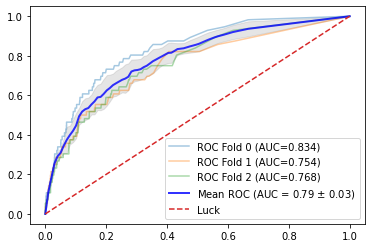

In [17]:
%%appyter code_exec
{% if 'roc_auc' in all_metrics %}
fig, ax = plt.subplots()

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

for fold, (train, test) in enumerate(cv.split(X.values, y)):
    model.fit(X.values[train], y[train])
    y_proba = model.predict_proba(X.values[test]) # Probability prediction will be True
    fpr, tpr, _ = sk.metrics.roc_curve(y[test], y_proba[:, 1])
    tprs.append(sp.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = sk.metrics.auc(fpr, tpr)
    aucs.append(roc_auc)
    ax.plot(fpr, tpr, alpha=0.4, label='ROC Fold %d (AUC=%0.3f)' % (fold, roc_auc))

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = sk.metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2)

ax.plot([0,1],[0,1],'--', label='Luck')
ax.legend()

z = (mean_auc - 0.5)/std_auc
cl = sp.stats.norm.cdf(z) * 100
ci = sp.stats.norm.interval(0.95, loc=mean_auc, scale=std_auc)
print('Confidence interval (95%)', ci)
print("We are %0.3f %% confident the model's results are not just chance." % (cl))
if cl > 95:
    print('This is statistically significant. These results can be trusted.')
else:
    print('This is not statistically significant. These results should not be trusted.')
{% endif %}

This will take a long time as we are evaluating n_iter different models n_splits different times each computing all the metrics on `product(X.shape)` data points--not to mention the size of each model dictated by the range of parameters specified in the params dict.

In [18]:
cm = metrics.confusion_matrix(y, model.predict(X.values))
display(cm)
print('\n',
    'True labels predicted to be true:', cm[0,0], '\n',
    'True labels predicted to be false:', cm[0,1], '\n',
    'False labels predicted to be true:', cm[1,0], '\n',
    'False labels predicted to be false:', cm[1,1])

array([[14259,     0],
       [   54,   114]])


 True labels predicted to be true: 14259 
 True labels predicted to be false: 0 
 False labels predicted to be true: 54 
 False labels predicted to be false: 114


## Examine drug predictions

In [19]:
# Obtain prediction results
y_probas = model.predict_proba(X)[:, 1]
results = pd.DataFrame(np.array([
    Drugmonizome.get_drug_names(X.index),
    y,
    (y_probas > 0.5).astype('float64'),
    y_probas,
]).T, columns=[
    'Name',
    'Known',
    'Predicted',
    'Prediction Probability',
], index=X.index).astype({'Known': 'float64', 'Predicted': 'float64', 'Prediction Probability': 'float64'})

In [23]:
# Rank drug hits
results[((results['Known'] == 1))].sort_values('Prediction Probability', ascending=False)

,Name,Known,Predicted,Prediction Probability
HQIRNZOQPUAHHV-UHFFFAOYSA-N,bupranolol,1.0,1.0,0.993452
XYCMOTOFHFTUIU-UHFFFAOYSA-N,cloranolol,1.0,1.0,0.993452
YKJYKKNCCRKFSL-RDBSUJKOSA-N,anisomycin,1.0,1.0,0.896546
QFJCIRLUMZQUOT-HPLJOQBZSA-N,sirolimus,1.0,1.0,0.860469
LPMXVESGRSUGHW-CIMHIGIKSA-N,ouabain,1.0,1.0,0.812655
LTMHDMANZUZIPE-QVYPYPLASA-N,digoxin,1.0,1.0,0.810647
LPMXVESGRSUGHW-XPXORLBYSA-N,ouabain,1.0,1.0,0.791630
IXFPJGBNCFXKPI-YBFXNURJSA-N,thapsigargin,1.0,1.0,0.782538
LTMHDMANZUZIPE-YUICGFAKSA-N,digoxin,1.0,1.0,0.781625
IYIKLHRQXLHMJQ-UHFFFAOYSA-N,amiodarone,1.0,1.0,0.763518


In [26]:
# Predict additional drugs
results[results['Known'] == 0].sort_values('Prediction Probability', ascending=False).head(25)

,Name,Known,Predicted,Prediction Probability
AZSNMRSAGSSBNP-ONDMGMIHSA-N,ivermectin,0.0,0.0,0.456892
ZOCUOMKMBMEYQV-GSLJADNHSA-N,isoflupredone acetate,0.0,0.0,0.438838
GOEMGAFJFRBGGG-UHFFFAOYSA-N,acebutolol,0.0,0.0,0.383575
QBILRDAMJUPXCX-RIBQKGKFSA-N,helveticoside,0.0,0.0,0.365089
LIRYPHYGHXZJBZ-UHFFFAOYSA-N,trametinib,0.0,0.0,0.351842
OUSFTKFNBAZUKL-UHFFFAOYSA-N,sns-032,0.0,0.0,0.329567
SUPVGFZUWFMATN-UHFFFAOYSA-N,pu-h71,0.0,0.0,0.309657
NXFQHRVNIOXGAQ-YCRREMRBSA-N,nitrofurantoin,0.0,0.0,0.294506
WPZSUTUAATWRPU-KVQBGUIXSA-M,"3-amino-4,5-dihydroxy-cyclohex-1-enecarboxylate",0.0,0.0,0.292793
CUIHSIWYWATEQL-UHFFFAOYSA-N,pazopanib,0.0,0.0,0.290336
